[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/me-manu/gammaALPs/blob/master/docs/tutorials/mixing_IGMF.ipynb)

# Mixing in the intergalactic magnetic field (IGMF)

This tutorial demonstrates photon-ALP mixing in the IGMF. The propagation also includes absorption in the extragalactic background light (EBL). The absorption is modeled through the `OptDepth` class of the `ebltable` python package. The implementation closely follows <a href="https://ui.adsabs.harvard.edu/abs/2011PhRvD..84j5030D/abstract">De Angelis et al. (2011)</a>.
The tutorial also shows how one can easily change the ALP parameters and rerun the calculations.

If you haven't installed `gammaALPs` already, you can do so using `pip`. Just uncomment the line below:

In [1]:
#!pip install gammaALPs

We start with the typical imports:

In [2]:
from gammaALPs.core import Source, ALP, ModuleList
from gammaALPs.base import environs, transfer
import numpy as np
import matplotlib.pyplot as plt
from ebltable.tau_from_model import OptDepth
from astropy import constants as c

Let's assume some generic source. Only the redshift will matter, as we won't include the mixing in the GMF.

In [3]:
src = Source(z=0.341, ra=0., dec=0.)

Let's init the module, only with mixing in the IGMF. We assume an unpolarized beam.

In [4]:
EGeV = np.logspace(1., 5., 200)
pin = np.diag((1.,1.,0.)) * 0.5

ml = ModuleList(ALP(m = 1., g = 6.), src, pin=pin, EGeV=EGeV, seed=0)

Next, we add the propagation in the IGMF with a B-field strength of $10^{-9}$G and coherence length of 1 Mpc (both strength and coherence length are given at $z=0$) and a constant electron density of the intergalactic medium of $10^{-7}\,\mathrm{cm}^{-3}$. We only calculate the mixing in one random realization (`nsim=1`)

In [5]:
ml.add_propagation("IGMF", 
                  0, # position of module counted from the source. 
                  nsim=1, # number of random B-field realizations
                  B0=1e-3,  # B field strength in micro Gauss at z = 0
                  n0=1e-7,  # normalization of electron density in cm^-3 at z = 0
                  L0=1e3, # coherence (cell) length in kpc at z = 0
                  eblmodel='dominguez' # EBL model
                  )

Now we step through some ALP masses and calculate the mixing probability

In [6]:
malp = np.array([0.001,0.01, 1., 10.])

First we initialize the arrays that will store the results

In [7]:
px = np.zeros((malp.shape[0], EGeV.shape[0]))
py = np.zeros((malp.shape[0], EGeV.shape[0]))
pa = np.zeros((malp.shape[0], EGeV.shape[0]))

And calculate the case without photon-ALP mixing, i.e., EBL absorption only:

In [8]:
tau = ml.modules["IGMFCell"].t.opt_depth(ml.source.z, ml.EGeV / 1e3)

The case with ALPs is computed in a loop over the considered ALP masses.

In [9]:
for i, mi in enumerate(malp):
    ml.alp.m = mi
    px[i], py[i], pa[i] = ml.run()

   core.py: 658 --- INFO: Running Module 0: <class 'gammaALPs.base.environs.MixIGMFCell'>
/Users/mey/Python/gammaALPs/gammaALPs/base/transfer.py:799: UserWarning: Not all values of linear polarization are real values!
  warnings.warn("Not all values of linear polarization are real values!")
/Users/mey/Python/gammaALPs/gammaALPs/base/transfer.py:802: UserWarning: Not all values of circular polarization are real values!
  warnings.warn("Not all values of circular polarization are real values!")
   core.py: 658 --- INFO: Running Module 0: <class 'gammaALPs.base.environs.MixIGMFCell'>
   core.py: 658 --- INFO: Running Module 0: <class 'gammaALPs.base.environs.MixIGMFCell'>
   core.py: 658 --- INFO: Running Module 0: <class 'gammaALPs.base.environs.MixIGMFCell'>


Finally, we plot the results for the different ALP masses and the no-ALP case.

Text(0, 0.5, 'Photon survial probability')

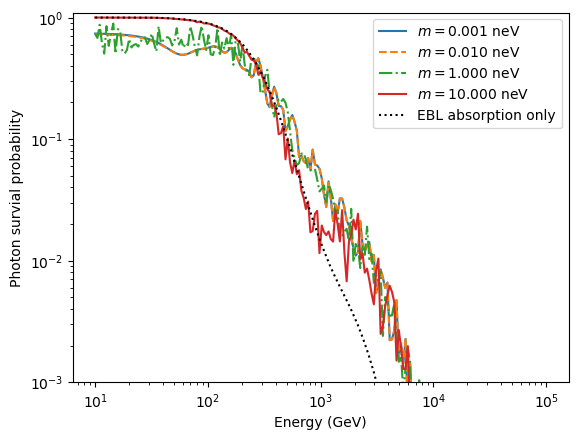

In [10]:
ls = ['-','--','-.']

for i, mi in enumerate(malp):
    plt.loglog(EGeV, px[i] + py[i], 
               label='$m = {0:.3f}$ neV'.format(mi),
               ls=ls[i % len(ls)])
    
plt.loglog(ml.EGeV, np.exp(-tau),
           label='EBL absorption only',
           color='k',
           ls=':')

plt.legend()
plt.gca().set_ylim(1e-3,1.1)
plt.xlabel('Energy (GeV)')
plt.ylabel('Photon survial probability')

You notice that with increasing mass the oscillations are shifted towards higher energies as the critical energy increases. For the lowest two masses, the curves are identical. The reason is that the difference between the plasma frequency becomes very small (and the difference $|m_a^2 - \omega_\mathrm{pl}^2|$ is what enters the critical energy).

You also see that at low energies the attenuation becomes stronger, whereas it decreased at higher energies. The reason is that as more and more photons are attenuated in the interaction with EBL photons, the component of ALPs reconverting into photons close to Earth becomes more and more visible.